In [1]:
import math
import pandas as pd
import numpy as np
import torch
import pickle
import tqdm
import inspect
import time

import arviz as az
from sbmfi.inference.discrete_flows import flow_constructor, flow_trainer
from sbmfi.priors.mog import MixtureOfGaussians

import arviz as az
import matplotlib.pyplot as plt

from sbmfi.core.coordinater import *
from sbmfi.inference.arxiv_polytope_plotter import plot_dataframes
from sbmfi.inference.continuous_flows import plot_losses_vs_steps

In [2]:
fcm, v_representation, volume = pickle.load(open('spiro_flux_coordinate_mapper.p', 'rb'))
psm = fcm.sampler
mog_data = az.from_netcdf( 'mog_polytope_105k_samples.nc')
means_df = pd.DataFrame(np.hstack([mog_data.attrs['mog_means'], mog_data.attrs['mog_weights'][:, None]]), columns=fcm.theta_id().append(pd.Index(['weights'])))

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.set_default_dtype(torch.float)
torch.manual_seed(42)

Using gpu


In [4]:
data = az.from_netcdf('mog_polytope_105k_samples.nc')
data = torch.as_tensor(az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values).T
data = map_rounded_2_ball(psm, data)
data = map_ball_2_cylinder(psm, data)

In [74]:
data = az.from_netcdf('mog_polytope_105k_samples.nc')
cylinder = torch.as_tensor(az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values).T
cylinder = map_rounded_2_ball(psm, cylinder)
cylinder = map_ball_2_cylinder(psm, cylinder).to(device=device, dtype=torch.float)
mog_target = MixtureOfGaussians(
    means=torch.as_tensor(data.attrs['mog_means'], dtype=torch.float), 
    covariances=torch.as_tensor(data.attrs['mog_covs'], dtype=torch.float),
    weights=torch.as_tensor(data.attrs['mog_weights'], dtype=torch.float),
    log_Z=np.log(mog_data.attrs['mog_Z']),
)
means_df = pd.DataFrame(
    np.hstack([data.attrs['mog_means'], data.attrs['mog_weights'][:, None]]), 
    columns=psm.rounded_id.append(pd.Index(['weights']))
)
mog_Z = data.attrs['mog_Z']
del data

In [6]:
flow_parameters = dict(
    coordinate_id='cylinder',
    embedding_net=None,
    num_context_channels=None,
    autoregressive=True,
    num_blocks=4,
    num_hidden_channels=64,
    num_bins=30,
    dropout_probability=0.01,
    num_transforms=10,
    init_identity=True,
    mixing_id='shuffle',
    use_lu=True,
    p=None,
    device=device,
)

flow = flow_constructor(
    fcm=fcm,
    **flow_parameters
)

In [7]:
batch_size = 1024 * 12
lr = 4e-3
weight_decay = 1e-3
gamma = 0.95
n_epoch = 35

dataset = torch.utils.data.TensorDataset(cylinder)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

optimizer = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma, last_epoch=-1)
steps = 0
losses=[]

In [8]:
t_start = time.time()
n_steps = n_epoch * len(dataloader)
pbar = tqdm.tqdm(total=n_steps, ncols=120, position=0)
try: 
    for epoch in range(n_epoch):
        for i, (chunk,)  in enumerate(dataloader):
            loss = flow.forward_kld(chunk)
            optimizer.zero_grad()
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()
            else:
                raise ValueError(f'loss: {loss}')
            loss_ = loss.item()
            losses.append(loss_)
            pbar.update()
            pbar.set_postfix(loss=round(loss_, 4))
        if (scheduler is not None):
            scheduler.step()
except KeyboardInterrupt:
    pass
except Exception as e:
    raise e
finally:
    pbar.close()

t_end = time.time()

 69%|███████████████████████████████████████████████▊                     | 312/450 [25:10<11:08,  4.84s/it, loss=-1.09]


In [39]:
flow_parameters_ = dict(
    **flow_parameters,
    tqdm_elapsed_time_s=pbar.last_print_t - pbar.start_t,
    batch_size = batch_size,
    lr=lr,
    weight_decay=weight_decay,
    gamma=gamma,
    n_epoch = n_epoch,
    losses=losses,
)

pickle.dump(flow_parameters_, open('spline_flow_parameters.p', 'wb'))
torch.save(flow.state_dict(), "spline_flow.pt")

In [10]:
flow_parameters_ = pickle.load(open('spline_flow_parameters.p', 'rb'))
losses = flow_parameters_['losses']

sig = inspect.signature(flow_constructor)
valid_keys = sig.parameters.keys()
flow_parameters = {k: v for k, v in flow_parameters_.items() if k in valid_keys}

recon_flow = flow_constructor(
    fcm=fcm,
    **flow_parameters
)
recon_flow.load_state_dict(torch.load("spline_flow.pt"))

C:\Users\diede\AppData\Local\Temp\ipykernel_14992\464716455.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recon_flow.load_state_dict(torch.load("spline_flow3.pt"))


<All keys matched successfully>

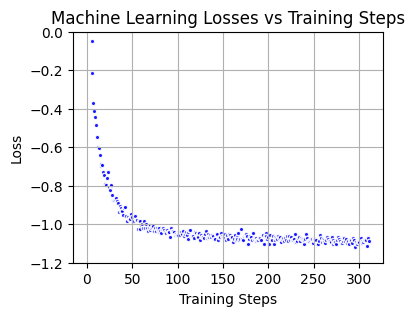

In [79]:
plot_losses_vs_steps(losses, axmax=0, axmin=-1.2)
plt.show()

In [70]:
n_test = 20000
t_sample_start = time.time()
with torch.no_grad():
    flow_samples, log_q = recon_flow.sample(n_test)
t_sample_elapsed = time.time() - t_sample_start
flow_cylinder, log_q = flow_samples.to(device='cpu', dtype=torch.double), log_q.to(device='cpu', dtype=torch.double)

In [71]:
flow_ball, J_bc = map_cylinder_2_ball(psm, flow_cylinder, rescale_val=1.0, jacobian=True)
flow_rounded, J_rb = map_ball_2_rounded(psm, flow_ball, jacobian=True)
flow_rounded_df = map_ball_2_rounded(psm, flow_ball, pandalize=True)
J_rc = fcm._la.tensormul_T(fcm._la.transax(J_bc), J_rb)

dets = fcm._la.det(J_rc)

In [80]:
log_p = mog_target.log_prob(flow_rounded)
log_qq = log_q - torch.log(abs(dets))

ws = torch.exp(log_p - log_qq)
KL_Z = ws.mean()
ln_KL = (log_p - log_qq).mean() + np.log(KL_Z)
KL = torch.exp(ln_KL)
ESS = ws.sum()**2 / (ws**2).sum()
in_pol = 0
print(f'ESS: {round(ESS.item() / n_test, 3)}, KL div.: {KL:.3e}, in pol: {in_pol / n_test}, training time: {flow_parameters_["tqdm_elapsed_time_s"]}, sampling time: {t_sample_elapsed}')

ESS: 0.857, KL div.: 6.747e-01, in pol: 0.0, training time: 1504.0570814609528, sampling time: 1.2947356700897217


In [81]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=v_representation,
    samples=flow_rounded_df,
    n_sample_cdf=10000,
    points=means_df,
    x_col='R_h_out', 
    y_col='R_biomass',
    x_label='R_h_out', 
    y_label='R_biomass',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
)
# plt.show()

In [82]:
plt.savefig(
    'spline_flow.svg', transparent=None, dpi='figure', format='svg',
    metadata=None, bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto', backend=None,
)